<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center><img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'></center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

# TL;DR

1. In this lab scenario you will have a chance to compare performance of the classic RNN and LSTM on a toy example.
2. This toy example will show that maintaining memory over even 20 steps is non-trivial.
3. Finally, you will see how curriculum learning may allow to train a model on larger sequences.

# Problem definition

Here we consider a toy example, where the goal is to discriminate between two types of binary sequences:
* [Type 0] a sequence with exactly one zero (remaining entries are equal to one).
* [Type 1] a sequence full of ones,

We are especially interested in the performance of the trained models on discriminating between a sequence full of ones versus a sequence with leading zero followed by ones. Note that in this case the goal of the model is to output the first element of the sequence, as the label (sequence type) is fully determined by the first element of the sequence.

#Implementation

## Importing torch

Install `torch` and `torchvision`

In [1]:
!pip3 install torch torchvision


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import List
from tqdm import tqdm

torch.manual_seed(1)

## Understand dimensionality

Check the input and output specification [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) and [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html). The following snippet shows how we can process
a sequence by LSTM and output a vector of size `hidden_dim` after reading
each token of the sequence.

In [3]:
hidden_dim = 5
lstm = nn.LSTM(1, hidden_dim)  # Input sequence contains elements - vectors of size 1

# create a random sequence
sequence = [torch.randn(1) for _ in range(10)]

# initialize the hidden state (including cell state)
hidden = (torch.zeros(1, 1, 5),
          torch.zeros(1, 1, 5))

for i, elem in enumerate(sequence):
  # we are processing only a single element of the sequence, and there
  # is only one sample (sequence) in the batch, the third one
  # corresponds to the fact that our sequence contains elemenents,
  # which can be treated as vectors of size 1
  out, hidden = lstm(elem.view(1, 1, 1), hidden)
  print(f'i={i} out={out.detach()}')
print(f'Final hidden state={hidden[0].detach()} cell state={hidden[1].detach()}')

i=0 out=tensor([[[-0.0675,  0.1179,  0.1081,  0.0414, -0.0341]]])
i=1 out=tensor([[[-0.1067,  0.1726,  0.1400,  0.0902, -0.0596]]])
i=2 out=tensor([[[-0.1148,  0.1885,  0.1956,  0.0974, -0.0840]]])
i=3 out=tensor([[[-0.1270,  0.2031,  0.1495,  0.1249, -0.0860]]])
i=4 out=tensor([[[-0.1281,  0.2019,  0.1810,  0.1475, -0.1027]]])
i=5 out=tensor([[[-0.1274,  0.2060,  0.0798,  0.1330, -0.0860]]])
i=6 out=tensor([[[-0.1318,  0.2039,  0.0997,  0.1772, -0.1011]]])
i=7 out=tensor([[[-0.1145,  0.2008, -0.0431,  0.1051, -0.0717]]])
i=8 out=tensor([[[-0.1289,  0.1989,  0.0515,  0.1944, -0.1030]]])
i=9 out=tensor([[[-0.1329,  0.1920,  0.0686,  0.1772, -0.0988]]])
Final hidden state=tensor([[[-0.1329,  0.1920,  0.0686,  0.1772, -0.0988]]]) cell state=tensor([[[-0.2590,  0.4080,  0.1307,  0.4329, -0.2895]]])


## To implement

Process the whole sequence all at once by calling `lstm` only once and check that the output is exactly the same as above (remember to initialize the hidden state the same way).

In [4]:
# #########################################################
#                    To implement
# #########################################################
hidden = (torch.zeros(1, 1, 5),
          torch.zeros(1, 1, 5))

out, hidden = lstm(torch.stack(sequence).view(len(sequence), 1, 1), hidden)

for i in range(len(sequence)):
  print(f'i={i} out={out[i].detach()}')
print(f'Final hidden state={hidden[0].detach()} cell state={hidden[1].detach()}')

i=0 out=tensor([[-0.0675,  0.1179,  0.1081,  0.0414, -0.0341]])
i=1 out=tensor([[-0.1067,  0.1726,  0.1400,  0.0902, -0.0596]])
i=2 out=tensor([[-0.1148,  0.1885,  0.1956,  0.0974, -0.0840]])
i=3 out=tensor([[-0.1270,  0.2031,  0.1495,  0.1249, -0.0860]])
i=4 out=tensor([[-0.1281,  0.2019,  0.1810,  0.1475, -0.1027]])
i=5 out=tensor([[-0.1274,  0.2060,  0.0798,  0.1330, -0.0860]])
i=6 out=tensor([[-0.1318,  0.2039,  0.0997,  0.1772, -0.1011]])
i=7 out=tensor([[-0.1145,  0.2008, -0.0431,  0.1051, -0.0717]])
i=8 out=tensor([[-0.1289,  0.1989,  0.0515,  0.1944, -0.1030]])
i=9 out=tensor([[-0.1329,  0.1920,  0.0686,  0.1772, -0.0988]])
Final hidden state=tensor([[[-0.1329,  0.1920,  0.0686,  0.1772, -0.0988]]]) cell state=tensor([[[-0.2590,  0.4080,  0.1307,  0.4329, -0.2895]]])


## Training a model

Below we define a very simple model, which is a single layer of LSTM, where the output in each time step is processed by relu followed by a single fully connected layer, the output of which is a single number. We are going
to use the number generated after reading the last element of the sequence,
which will serve as the logit for our classification problem.

In [5]:
class Model(nn.Module):

    def __init__(self, hidden_dim: int):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(1, self.hidden_dim)
        self.hidden2label = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out, _ = self.lstm(x)
        sequence_len = x.shape[0]
        logits = self.hidden2label(F.relu(out[-1]))
        return logits

Below is a training loop, where we only train on the two hardest examples.

In [6]:
SEQUENCE_LEN = 10

# Pairs of (sequence, label)
HARD_EXAMPLES = [([0.]+(SEQUENCE_LEN-1)*[1.], 0),
                 (SEQUENCE_LEN*[1.], 1)]


def eval_on_hard_examples(model: nn.Module) -> List[float]:
    with torch.no_grad():
        logits = []
        for sequence in HARD_EXAMPLES:
            input = torch.tensor(sequence[0]).view(-1, 1, 1)
            logit = model(input)
            logits.append(logit.detach())
        print(f'Logits for hard examples={logits}')
        return logits


def train_model(hidden_dim: int, lr: float, num_steps:int = 10000) -> None:
    model = Model(hidden_dim=hidden_dim)
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.99)

    pbar = tqdm(range(num_steps))
    for step in pbar:
        if step % 100 == 0:
            logits = eval_on_hard_examples(model)
            pbar.set_postfix(logits=logits)

        for sequence, label in HARD_EXAMPLES:
            model.zero_grad()
            logit = model(torch.tensor(sequence).view(-1, 1, 1))

            loss = loss_function(logit.view(-1), torch.tensor([label], dtype=torch.float32))
            loss.backward()

            optimizer.step()

In [7]:
train_model(hidden_dim=20, lr=0.01, num_steps=10000)

  1%|          | 78/10000 [00:00<00:25, 396.36it/s, logits=[tensor([[-0.1775]]), tensor([[-0.1774]])]]

Logits for hard examples=[tensor([[-0.1775]]), tensor([[-0.1774]])]


  2%|▏         | 164/10000 [00:00<00:23, 416.32it/s, logits=[tensor([[0.0095]]), tensor([[0.0097]])]] 

Logits for hard examples=[tensor([[0.0095]]), tensor([[0.0097]])]


  3%|▎         | 253/10000 [00:00<00:22, 429.07it/s, logits=[tensor([[0.0259]]), tensor([[0.0263]])]]

Logits for hard examples=[tensor([[0.0259]]), tensor([[0.0263]])]


  4%|▍         | 385/10000 [00:00<00:22, 429.43it/s, logits=[tensor([[-0.0017]]), tensor([[-0.0009]])]]

Logits for hard examples=[tensor([[-0.0017]]), tensor([[-0.0009]])]


  5%|▍         | 472/10000 [00:01<00:22, 430.48it/s, logits=[tensor([[-0.0034]]), tensor([[7.1801e-05]])]]

Logits for hard examples=[tensor([[-0.0034]]), tensor([[7.1801e-05]])]


  6%|▌         | 560/10000 [00:01<00:21, 430.63it/s, logits=[tensor([[-3.0632]]), tensor([[3.5531]])]]    

Logits for hard examples=[tensor([[-3.0632]]), tensor([[3.5531]])]


  6%|▋         | 649/10000 [00:01<00:21, 434.38it/s, logits=[tensor([[-11.0094]]), tensor([[10.8645]])]]

Logits for hard examples=[tensor([[-11.0094]]), tensor([[10.8645]])]


  7%|▋         | 737/10000 [00:01<00:21, 422.65it/s, logits=[tensor([[-12.1567]]), tensor([[11.9191]])]]

Logits for hard examples=[tensor([[-12.1567]]), tensor([[11.9191]])]


  9%|▊         | 865/10000 [00:02<00:22, 399.35it/s, logits=[tensor([[-12.3136]]), tensor([[12.0644]])]]

Logits for hard examples=[tensor([[-12.3136]]), tensor([[12.0644]])]


 10%|▉         | 952/10000 [00:02<00:21, 414.71it/s, logits=[tensor([[-12.3368]]), tensor([[12.0874]])]]

Logits for hard examples=[tensor([[-12.3368]]), tensor([[12.0874]])]


 11%|█         | 1083/10000 [00:02<00:20, 425.94it/s, logits=[tensor([[-12.3421]]), tensor([[12.0939]])]]

Logits for hard examples=[tensor([[-12.3421]]), tensor([[12.0939]])]


 12%|█▏        | 1171/10000 [00:02<00:20, 427.43it/s, logits=[tensor([[-12.3448]]), tensor([[12.0982]])]]

Logits for hard examples=[tensor([[-12.3448]]), tensor([[12.0982]])]


 13%|█▎        | 1257/10000 [00:03<00:21, 415.79it/s, logits=[tensor([[-12.3473]]), tensor([[12.1022]])]]

Logits for hard examples=[tensor([[-12.3473]]), tensor([[12.1022]])]


 14%|█▍        | 1385/10000 [00:03<00:20, 421.18it/s, logits=[tensor([[-12.3498]]), tensor([[12.1062]])]]

Logits for hard examples=[tensor([[-12.3498]]), tensor([[12.1062]])]


 15%|█▍        | 1472/10000 [00:03<00:20, 426.37it/s, logits=[tensor([[-12.3523]]), tensor([[12.1101]])]]

Logits for hard examples=[tensor([[-12.3523]]), tensor([[12.1101]])]


 16%|█▌        | 1559/10000 [00:03<00:19, 426.94it/s, logits=[tensor([[-12.3547]]), tensor([[12.1140]])]]

Logits for hard examples=[tensor([[-12.3547]]), tensor([[12.1140]])]


 16%|█▋        | 1645/10000 [00:03<00:19, 427.72it/s, logits=[tensor([[-12.3571]]), tensor([[12.1179]])]]

Logits for hard examples=[tensor([[-12.3571]]), tensor([[12.1179]])]


 18%|█▊        | 1778/10000 [00:04<00:18, 435.20it/s, logits=[tensor([[-12.3595]]), tensor([[12.1218]])]]

Logits for hard examples=[tensor([[-12.3595]]), tensor([[12.1218]])]


 19%|█▊        | 1866/10000 [00:04<00:18, 430.58it/s, logits=[tensor([[-12.3619]]), tensor([[12.1257]])]]

Logits for hard examples=[tensor([[-12.3619]]), tensor([[12.1257]])]


 20%|█▉        | 1954/10000 [00:04<00:18, 429.90it/s, logits=[tensor([[-12.3643]]), tensor([[12.1295]])]]

Logits for hard examples=[tensor([[-12.3643]]), tensor([[12.1295]])]


 21%|██        | 2086/10000 [00:04<00:18, 430.63it/s, logits=[tensor([[-12.3667]]), tensor([[12.1333]])]]

Logits for hard examples=[tensor([[-12.3667]]), tensor([[12.1333]])]


 22%|██▏       | 2175/10000 [00:05<00:18, 432.42it/s, logits=[tensor([[-12.3691]]), tensor([[12.1372]])]]

Logits for hard examples=[tensor([[-12.3691]]), tensor([[12.1372]])]


 23%|██▎       | 2263/10000 [00:05<00:17, 432.44it/s, logits=[tensor([[-12.3714]]), tensor([[12.1410]])]]

Logits for hard examples=[tensor([[-12.3714]]), tensor([[12.1410]])]


 24%|██▎       | 2352/10000 [00:05<00:17, 433.43it/s, logits=[tensor([[-12.3737]]), tensor([[12.1448]])]]

Logits for hard examples=[tensor([[-12.3737]]), tensor([[12.1448]])]


 25%|██▍       | 2485/10000 [00:05<00:17, 433.38it/s, logits=[tensor([[-12.3761]]), tensor([[12.1486]])]]

Logits for hard examples=[tensor([[-12.3761]]), tensor([[12.1486]])]


 26%|██▌       | 2573/10000 [00:06<00:17, 432.92it/s, logits=[tensor([[-12.3784]]), tensor([[12.1523]])]]

Logits for hard examples=[tensor([[-12.3784]]), tensor([[12.1523]])]


 27%|██▋       | 2662/10000 [00:06<00:16, 435.19it/s, logits=[tensor([[-12.3808]]), tensor([[12.1560]])]]

Logits for hard examples=[tensor([[-12.3808]]), tensor([[12.1560]])]


 28%|██▊       | 2751/10000 [00:06<00:16, 435.19it/s, logits=[tensor([[-12.3831]]), tensor([[12.1597]])]]

Logits for hard examples=[tensor([[-12.3831]]), tensor([[12.1597]])]


 29%|██▉       | 2883/10000 [00:06<00:16, 435.61it/s, logits=[tensor([[-12.3854]]), tensor([[12.1634]])]]

Logits for hard examples=[tensor([[-12.3854]]), tensor([[12.1634]])]


 30%|██▉       | 2971/10000 [00:06<00:16, 434.18it/s, logits=[tensor([[-12.3877]]), tensor([[12.1670]])]]

Logits for hard examples=[tensor([[-12.3877]]), tensor([[12.1670]])]


 31%|███       | 3059/10000 [00:07<00:16, 432.03it/s, logits=[tensor([[-12.3900]]), tensor([[12.1707]])]]

Logits for hard examples=[tensor([[-12.3900]]), tensor([[12.1707]])]


 31%|███▏      | 3148/10000 [00:07<00:15, 435.08it/s, logits=[tensor([[-12.3923]]), tensor([[12.1743]])]]

Logits for hard examples=[tensor([[-12.3923]]), tensor([[12.1743]])]


 33%|███▎      | 3280/10000 [00:07<00:15, 431.99it/s, logits=[tensor([[-12.3946]]), tensor([[12.1779]])]]

Logits for hard examples=[tensor([[-12.3946]]), tensor([[12.1779]])]


 34%|███▎      | 3369/10000 [00:07<00:15, 434.29it/s, logits=[tensor([[-12.3969]]), tensor([[12.1814]])]]

Logits for hard examples=[tensor([[-12.3969]]), tensor([[12.1814]])]


 35%|███▍      | 3458/10000 [00:08<00:15, 433.69it/s, logits=[tensor([[-12.3992]]), tensor([[12.1850]])]]

Logits for hard examples=[tensor([[-12.3992]]), tensor([[12.1850]])]


 35%|███▌      | 3547/10000 [00:08<00:14, 437.87it/s, logits=[tensor([[-12.4015]]), tensor([[12.1886]])]]

Logits for hard examples=[tensor([[-12.4015]]), tensor([[12.1886]])]


 37%|███▋      | 3681/10000 [00:08<00:14, 435.84it/s, logits=[tensor([[-12.4038]]), tensor([[12.1922]])]]

Logits for hard examples=[tensor([[-12.4038]]), tensor([[12.1922]])]


 38%|███▊      | 3770/10000 [00:08<00:14, 434.47it/s, logits=[tensor([[-12.4061]]), tensor([[12.1957]])]]

Logits for hard examples=[tensor([[-12.4061]]), tensor([[12.1957]])]


 39%|███▊      | 3859/10000 [00:09<00:14, 434.78it/s, logits=[tensor([[-12.4084]]), tensor([[12.1992]])]]

Logits for hard examples=[tensor([[-12.4084]]), tensor([[12.1992]])]


 39%|███▉      | 3946/10000 [00:09<00:14, 427.55it/s, logits=[tensor([[-12.4106]]), tensor([[12.2027]])]]

Logits for hard examples=[tensor([[-12.4106]]), tensor([[12.2027]])]


 40%|████      | 4032/10000 [00:09<00:14, 412.68it/s, logits=[tensor([[-12.4129]]), tensor([[12.2063]])]]

Logits for hard examples=[tensor([[-12.4129]]), tensor([[12.2063]])]


 42%|████▏     | 4156/10000 [00:09<00:15, 384.42it/s, logits=[tensor([[-12.4152]]), tensor([[12.2098]])]]

Logits for hard examples=[tensor([[-12.4152]]), tensor([[12.2098]])]


 43%|████▎     | 4283/10000 [00:10<00:14, 405.89it/s, logits=[tensor([[-12.4175]]), tensor([[12.2133]])]]

Logits for hard examples=[tensor([[-12.4175]]), tensor([[12.2133]])]


 44%|████▎     | 4368/10000 [00:10<00:13, 414.58it/s, logits=[tensor([[-12.4197]]), tensor([[12.2168]])]]

Logits for hard examples=[tensor([[-12.4197]]), tensor([[12.2168]])]


 45%|████▍     | 4452/10000 [00:10<00:13, 412.98it/s, logits=[tensor([[-12.4220]]), tensor([[12.2203]])]]

Logits for hard examples=[tensor([[-12.4220]]), tensor([[12.2203]])]


 46%|████▌     | 4580/10000 [00:10<00:12, 417.45it/s, logits=[tensor([[-12.4242]]), tensor([[12.2237]])]]

Logits for hard examples=[tensor([[-12.4242]]), tensor([[12.2237]])]


 47%|████▋     | 4665/10000 [00:11<00:12, 418.10it/s, logits=[tensor([[-12.4265]]), tensor([[12.2271]])]]

Logits for hard examples=[tensor([[-12.4265]]), tensor([[12.2271]])]


 48%|████▊     | 4750/10000 [00:11<00:12, 420.02it/s, logits=[tensor([[-12.4287]]), tensor([[12.2306]])]]

Logits for hard examples=[tensor([[-12.4287]]), tensor([[12.2306]])]


 49%|████▉     | 4880/10000 [00:11<00:12, 421.60it/s, logits=[tensor([[-12.4310]]), tensor([[12.2340]])]]

Logits for hard examples=[tensor([[-12.4310]]), tensor([[12.2340]])]


 50%|████▉     | 4965/10000 [00:11<00:12, 409.04it/s, logits=[tensor([[-12.4332]]), tensor([[12.2374]])]]

Logits for hard examples=[tensor([[-12.4332]]), tensor([[12.2374]])]


 50%|█████     | 5050/10000 [00:11<00:11, 414.06it/s, logits=[tensor([[-12.4355]]), tensor([[12.2409]])]]

Logits for hard examples=[tensor([[-12.4355]]), tensor([[12.2409]])]


 52%|█████▏    | 5180/10000 [00:12<00:11, 422.11it/s, logits=[tensor([[-12.4377]]), tensor([[12.2443]])]]

Logits for hard examples=[tensor([[-12.4377]]), tensor([[12.2443]])]


 53%|█████▎    | 5266/10000 [00:12<00:11, 420.23it/s, logits=[tensor([[-12.4400]]), tensor([[12.2476]])]]

Logits for hard examples=[tensor([[-12.4400]]), tensor([[12.2476]])]


 54%|█████▎    | 5352/10000 [00:12<00:11, 419.77it/s, logits=[tensor([[-12.4422]]), tensor([[12.2510]])]]

Logits for hard examples=[tensor([[-12.4422]]), tensor([[12.2510]])]


 55%|█████▍    | 5483/10000 [00:12<00:10, 425.74it/s, logits=[tensor([[-12.4445]]), tensor([[12.2543]])]]

Logits for hard examples=[tensor([[-12.4445]]), tensor([[12.2543]])]


 56%|█████▌    | 5571/10000 [00:13<00:10, 429.35it/s, logits=[tensor([[-12.4467]]), tensor([[12.2577]])]]

Logits for hard examples=[tensor([[-12.4467]]), tensor([[12.2577]])]


 57%|█████▋    | 5657/10000 [00:13<00:10, 427.54it/s, logits=[tensor([[-12.4489]]), tensor([[12.2610]])]]

Logits for hard examples=[tensor([[-12.4489]]), tensor([[12.2610]])]


 57%|█████▋    | 5745/10000 [00:13<00:09, 430.13it/s, logits=[tensor([[-12.4511]]), tensor([[12.2644]])]]

Logits for hard examples=[tensor([[-12.4511]]), tensor([[12.2644]])]


 59%|█████▉    | 5875/10000 [00:13<00:09, 427.07it/s, logits=[tensor([[-12.4534]]), tensor([[12.2677]])]]

Logits for hard examples=[tensor([[-12.4534]]), tensor([[12.2677]])]


 60%|█████▉    | 5962/10000 [00:14<00:09, 424.48it/s, logits=[tensor([[-12.4556]]), tensor([[12.2710]])]]

Logits for hard examples=[tensor([[-12.4556]]), tensor([[12.2710]])]


 60%|██████    | 6048/10000 [00:14<00:09, 419.46it/s, logits=[tensor([[-12.4578]]), tensor([[12.2743]])]]

Logits for hard examples=[tensor([[-12.4578]]), tensor([[12.2743]])]


 62%|██████▏   | 6178/10000 [00:14<00:09, 423.33it/s, logits=[tensor([[-12.4600]]), tensor([[12.2776]])]]

Logits for hard examples=[tensor([[-12.4600]]), tensor([[12.2776]])]


 63%|██████▎   | 6264/10000 [00:14<00:08, 422.14it/s, logits=[tensor([[-12.4622]]), tensor([[12.2809]])]]

Logits for hard examples=[tensor([[-12.4622]]), tensor([[12.2809]])]


 64%|██████▎   | 6350/10000 [00:15<00:08, 421.92it/s, logits=[tensor([[-12.4644]]), tensor([[12.2842]])]]

Logits for hard examples=[tensor([[-12.4644]]), tensor([[12.2842]])]


 65%|██████▍   | 6479/10000 [00:15<00:08, 424.25it/s, logits=[tensor([[-12.4666]]), tensor([[12.2874]])]]

Logits for hard examples=[tensor([[-12.4666]]), tensor([[12.2874]])]


 66%|██████▌   | 6566/10000 [00:15<00:08, 423.67it/s, logits=[tensor([[-12.4688]]), tensor([[12.2907]])]]

Logits for hard examples=[tensor([[-12.4688]]), tensor([[12.2907]])]


 67%|██████▋   | 6653/10000 [00:15<00:07, 426.53it/s, logits=[tensor([[-12.4710]]), tensor([[12.2940]])]]

Logits for hard examples=[tensor([[-12.4710]]), tensor([[12.2940]])]


 68%|██████▊   | 6782/10000 [00:16<00:07, 425.61it/s, logits=[tensor([[-12.4732]]), tensor([[12.2972]])]]

Logits for hard examples=[tensor([[-12.4732]]), tensor([[12.2972]])]


 69%|██████▊   | 6869/10000 [00:16<00:07, 429.15it/s, logits=[tensor([[-12.4753]]), tensor([[12.3004]])]]

Logits for hard examples=[tensor([[-12.4753]]), tensor([[12.3004]])]


 70%|██████▉   | 6955/10000 [00:16<00:07, 414.18it/s, logits=[tensor([[-12.4775]]), tensor([[12.3036]])]]

Logits for hard examples=[tensor([[-12.4775]]), tensor([[12.3036]])]


 71%|███████   | 7086/10000 [00:16<00:06, 424.91it/s, logits=[tensor([[-12.4797]]), tensor([[12.3069]])]]

Logits for hard examples=[tensor([[-12.4797]]), tensor([[12.3069]])]


 72%|███████▏  | 7173/10000 [00:16<00:06, 426.34it/s, logits=[tensor([[-12.4819]]), tensor([[12.3101]])]]

Logits for hard examples=[tensor([[-12.4819]]), tensor([[12.3101]])]


 73%|███████▎  | 7261/10000 [00:17<00:06, 430.74it/s, logits=[tensor([[-12.4841]]), tensor([[12.3133]])]]

Logits for hard examples=[tensor([[-12.4841]]), tensor([[12.3133]])]


 73%|███████▎  | 7349/10000 [00:17<00:06, 430.00it/s, logits=[tensor([[-12.4862]]), tensor([[12.3165]])]]

Logits for hard examples=[tensor([[-12.4862]]), tensor([[12.3165]])]


 75%|███████▍  | 7480/10000 [00:17<00:05, 427.99it/s, logits=[tensor([[-12.4884]]), tensor([[12.3197]])]]

Logits for hard examples=[tensor([[-12.4884]]), tensor([[12.3197]])]


 76%|███████▌  | 7568/10000 [00:17<00:05, 430.65it/s, logits=[tensor([[-12.4906]]), tensor([[12.3228]])]]

Logits for hard examples=[tensor([[-12.4906]]), tensor([[12.3228]])]


 77%|███████▋  | 7656/10000 [00:18<00:05, 429.59it/s, logits=[tensor([[-12.4928]]), tensor([[12.3259]])]]

Logits for hard examples=[tensor([[-12.4928]]), tensor([[12.3259]])]


 78%|███████▊  | 7785/10000 [00:18<00:05, 427.07it/s, logits=[tensor([[-12.4950]]), tensor([[12.3290]])]]

Logits for hard examples=[tensor([[-12.4950]]), tensor([[12.3290]])]


 79%|███████▊  | 7871/10000 [00:18<00:05, 425.70it/s, logits=[tensor([[-12.4971]]), tensor([[12.3321]])]]

Logits for hard examples=[tensor([[-12.4971]]), tensor([[12.3321]])]


 80%|███████▉  | 7957/10000 [00:18<00:04, 416.84it/s, logits=[tensor([[-12.4993]]), tensor([[12.3352]])]]

Logits for hard examples=[tensor([[-12.4993]]), tensor([[12.3352]])]


 80%|████████  | 8042/10000 [00:19<00:04, 414.42it/s, logits=[tensor([[-12.5015]]), tensor([[12.3384]])]]

Logits for hard examples=[tensor([[-12.5015]]), tensor([[12.3384]])]


 82%|████████▏ | 8171/10000 [00:19<00:04, 420.47it/s, logits=[tensor([[-12.5036]]), tensor([[12.3415]])]]

Logits for hard examples=[tensor([[-12.5036]]), tensor([[12.3415]])]


 83%|████████▎ | 8257/10000 [00:19<00:04, 419.80it/s, logits=[tensor([[-12.5058]]), tensor([[12.3446]])]]

Logits for hard examples=[tensor([[-12.5058]]), tensor([[12.3446]])]


 83%|████████▎ | 8343/10000 [00:19<00:03, 419.04it/s, logits=[tensor([[-12.5079]]), tensor([[12.3477]])]]

Logits for hard examples=[tensor([[-12.5079]]), tensor([[12.3477]])]


 85%|████████▍ | 8473/10000 [00:20<00:03, 425.13it/s, logits=[tensor([[-12.5101]]), tensor([[12.3507]])]]

Logits for hard examples=[tensor([[-12.5101]]), tensor([[12.3507]])]


 86%|████████▌ | 8559/10000 [00:20<00:03, 420.39it/s, logits=[tensor([[-12.5123]]), tensor([[12.3537]])]]

Logits for hard examples=[tensor([[-12.5123]]), tensor([[12.3537]])]


 86%|████████▋ | 8646/10000 [00:20<00:03, 426.62it/s, logits=[tensor([[-12.5144]]), tensor([[12.3566]])]]

Logits for hard examples=[tensor([[-12.5144]]), tensor([[12.3566]])]


 88%|████████▊ | 8775/10000 [00:20<00:02, 422.27it/s, logits=[tensor([[-12.5166]]), tensor([[12.3596]])]]

Logits for hard examples=[tensor([[-12.5166]]), tensor([[12.3596]])]


 89%|████████▊ | 8861/10000 [00:20<00:02, 422.94it/s, logits=[tensor([[-12.5188]]), tensor([[12.3626]])]]

Logits for hard examples=[tensor([[-12.5188]]), tensor([[12.3626]])]


 89%|████████▉ | 8947/10000 [00:21<00:02, 420.02it/s, logits=[tensor([[-12.5209]]), tensor([[12.3656]])]]

Logits for hard examples=[tensor([[-12.5209]]), tensor([[12.3656]])]


 91%|█████████ | 9076/10000 [00:21<00:02, 418.62it/s, logits=[tensor([[-12.5231]]), tensor([[12.3685]])]]

Logits for hard examples=[tensor([[-12.5231]]), tensor([[12.3685]])]


 92%|█████████▏| 9161/10000 [00:21<00:02, 418.77it/s, logits=[tensor([[-12.5252]]), tensor([[12.3715]])]]

Logits for hard examples=[tensor([[-12.5252]]), tensor([[12.3715]])]


 92%|█████████▏| 9248/10000 [00:21<00:01, 422.07it/s, logits=[tensor([[-12.5274]]), tensor([[12.3745]])]]

Logits for hard examples=[tensor([[-12.5274]]), tensor([[12.3745]])]


 94%|█████████▍| 9378/10000 [00:22<00:01, 424.71it/s, logits=[tensor([[-12.5295]]), tensor([[12.3773]])]]

Logits for hard examples=[tensor([[-12.5295]]), tensor([[12.3773]])]


 95%|█████████▍| 9464/10000 [00:22<00:01, 423.79it/s, logits=[tensor([[-12.5317]]), tensor([[12.3802]])]]

Logits for hard examples=[tensor([[-12.5317]]), tensor([[12.3802]])]


 96%|█████████▌| 9551/10000 [00:22<00:01, 428.36it/s, logits=[tensor([[-12.5338]]), tensor([[12.3831]])]]

Logits for hard examples=[tensor([[-12.5338]]), tensor([[12.3831]])]


 97%|█████████▋| 9681/10000 [00:22<00:00, 425.50it/s, logits=[tensor([[-12.5359]]), tensor([[12.3860]])]]

Logits for hard examples=[tensor([[-12.5359]]), tensor([[12.3860]])]


 98%|█████████▊| 9768/10000 [00:23<00:00, 426.98it/s, logits=[tensor([[-12.5381]]), tensor([[12.3889]])]]

Logits for hard examples=[tensor([[-12.5381]]), tensor([[12.3889]])]


 99%|█████████▊| 9855/10000 [00:23<00:00, 425.95it/s, logits=[tensor([[-12.5402]]), tensor([[12.3918]])]]

Logits for hard examples=[tensor([[-12.5402]]), tensor([[12.3918]])]


100%|█████████▉| 9985/10000 [00:23<00:00, 425.94it/s, logits=[tensor([[-12.5423]]), tensor([[12.3946]])]]

Logits for hard examples=[tensor([[-12.5423]]), tensor([[12.3946]])]


100%|██████████| 10000/10000 [00:23<00:00, 423.08it/s, logits=[tensor([[-12.5423]]), tensor([[12.3946]])]]


## To implement

1. Check for what values of `SEQUENCE_LEN` the model is able to discriminate betweeh the two hard examples (after training).
2. Instead of training on `HARD_EXAMPLES` only, modify the training loop to train on sequences where zero may be in any position of the sequence (so any valid sequence of `Type 0`, not just the hardest one). After modifying the training loop check for what values of `SEQUENCE_LEN` you can train the model successfully.
3. Replace LSTM by a classic RNN and check for what values of `SEQUENCE_LEN` you can train the model successfully.
4. Write a proper curricullum learning loop, where in a loop you consider longer and longer sequences, where expansion of the sequence length happens only after the model is trained successfully on the current length.

Note that for steps 2-4 you may need to change the value of `num_steps`.

### Task 1:
Check for what values of `SEQUENCE_LEN` the model is able to discriminate betweeh the two hard examples (after training).

In [8]:
def eval_accuracy(model : nn.Module, x : list[list[float]], y : list[int]) -> float:
    with torch.no_grad():
        correct = 0
        for sequence, label in zip(x, y):
            input = torch.tensor(sequence).view(-1, 1, 1)
            logit = torch.nn.functional.sigmoid(model(input))
            if int(logit > 0.5) == label:
                correct += 1

        accuracy = correct / len(x)
        return accuracy

def train(hidden_dim: int, lr: float, num_steps:int = 10000, data = HARD_EXAMPLES) -> nn.Module:
    device = "cpu"
    model = Model(hidden_dim=hidden_dim).to(device)
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.99)

    pbar = tqdm(range(num_steps))
    for _ in pbar:

        for sequence, label in data:
            model.zero_grad()
            logit = model(torch.tensor(sequence).view(-1, 1, 1).to(device))

            loss = loss_function(logit.view(-1), torch.tensor([label], dtype=torch.float32).to(device))
            loss.backward()

            optimizer.step()

    return model
    

In [9]:
model = train(hidden_dim=20, lr=0.01, num_steps=1000, data=HARD_EXAMPLES)
results = {}

for seq_len in range(10, 1000, 10):
    hard_examples = [([0.]+(seq_len -1)*[1.], 0),
                 (seq_len *[1.], 1)]
    
    results[seq_len] = eval_accuracy(model, [sequence for sequence, _ in HARD_EXAMPLES],
              [label for _, label in HARD_EXAMPLES])

100%|██████████| 1000/1000 [00:02<00:00, 424.23it/s]


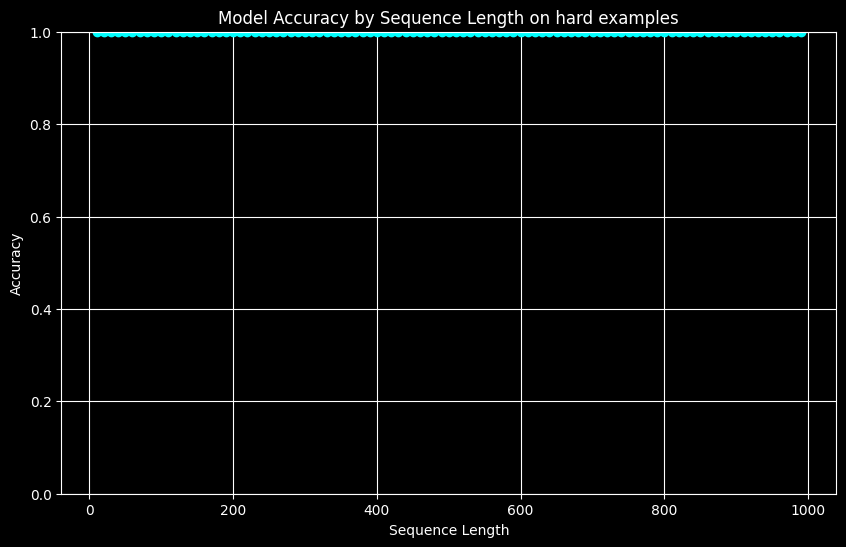

In [10]:
import matplotlib.pyplot as plt
sequence_lengths = list(results.keys())
accuracies = list(results.values())

plt.style.use('dark_background')

plt.figure(figsize=(10, 6))
plt.plot(sequence_lengths, accuracies, marker='o', color='cyan')
plt.title('Model Accuracy by Sequence Length on hard examples', color='white')
plt.xlabel('Sequence Length', color='white')
plt.ylabel('Accuracy', color='white')
plt.ylim(0, 1) 
plt.grid(True)
plt.show()

### Task 2

Instead of training on `HARD_EXAMPLES` only, modify the training loop to train on sequences where zero may be in any position of the sequence (so any valid sequence of `Type 0`, not just the hardest one). After modifying the training loop check for what values of `SEQUENCE_LEN` you can train the model successfully.

In [11]:
def generate_data(sequence_len: int, num_examples: int):
    x = []
    y = []
    for _ in range(num_examples):
        sequence = sequence_len * [1.]
        label = 1
        if torch.rand(1) > 0.5:
            sequence[torch.randint(0, sequence_len, (1,))[0]] = 0.
            label = 0

        x.append(sequence)
        y.append(label)

    return list(zip(x, y))

In [12]:
acc = {}

for seq_len in range(10, 100, 10):
    data = generate_data(sequence_len=seq_len, num_examples=100)
    test_data = generate_data(sequence_len=seq_len, num_examples=10)
    model = train(hidden_dim=20, lr=0.01, num_steps=100, data=data)
    x, y = ([sequence for sequence, _ in test_data],
              [label for _, label in test_data])
    acc[seq_len] = eval_accuracy(model, x, y)


100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


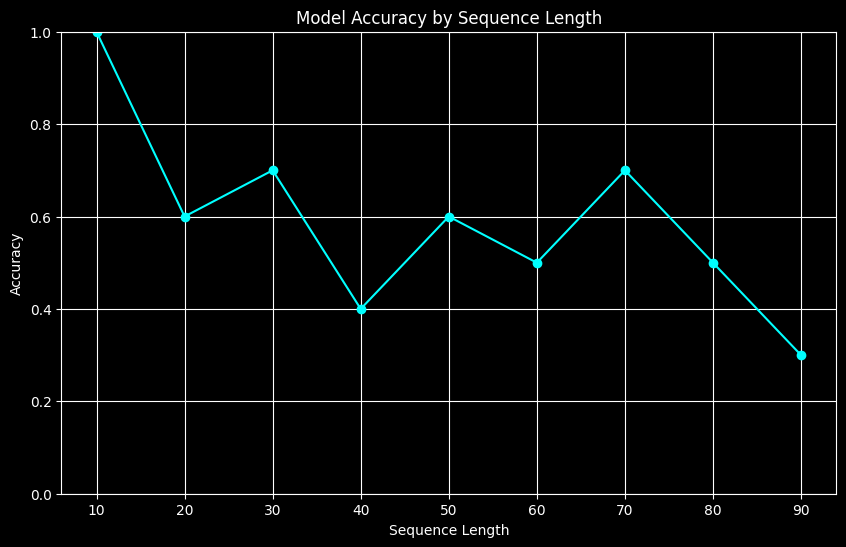

In [13]:
sequence_lengths = list(acc.keys())
accuracies = list(acc.values())
plt.figure(figsize=(10, 6))
plt.plot(sequence_lengths, accuracies, marker='o', color='cyan')
plt.title('Model Accuracy by Sequence Length', color='white')
plt.xlabel('Sequence Length', color='white')
plt.ylabel('Accuracy', color='white')
plt.ylim(0, 1) 
plt.grid(True)
plt.show()

### Task 3

Replace LSTM by a classic RNN and check for what values of `SEQUENCE_LEN` you can train the model successfully.

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNNModel(nn.Module):
    def __init__(self, hidden_dim: int):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_size=1, hidden_size=self.hidden_dim)
        self.hidden2label = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out, _ = self.rnn(x)
        logits = self.hidden2label(F.relu(out[-1]))
        return logits
    

def train_rnn(hidden_dim: int, lr: float, num_steps:int = 10000, data = HARD_EXAMPLES) -> nn.Module:
    device = "cpu"
    model = RNNModel(hidden_dim=hidden_dim).to(device)
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.99)

    pbar = tqdm(range(num_steps))
    for _ in pbar:

        for sequence, label in data:
            model.zero_grad()
            logit = model(torch.tensor(sequence).view(-1, 1, 1).to(device))

            loss = loss_function(logit.view(-1), torch.tensor([label], dtype=torch.float32).to(device))
            loss.backward()

            optimizer.step()

    return model

In [18]:
rnn_acc = {}

for seq_len in range(10, 100, 10):
    data = generate_data(sequence_len=seq_len, num_examples=100)
    test_data = generate_data(sequence_len=seq_len, num_examples=10)
    model = train_rnn(hidden_dim=20, lr=0.01, num_steps=100, data=data)
    x, y = ([sequence for sequence, _ in test_data],
              [label for _, label in test_data])
    rnn_acc[seq_len] = eval_accuracy(model, x, y)

100%|██████████| 100/100 [04:31<00:00,  2.71s/it] 


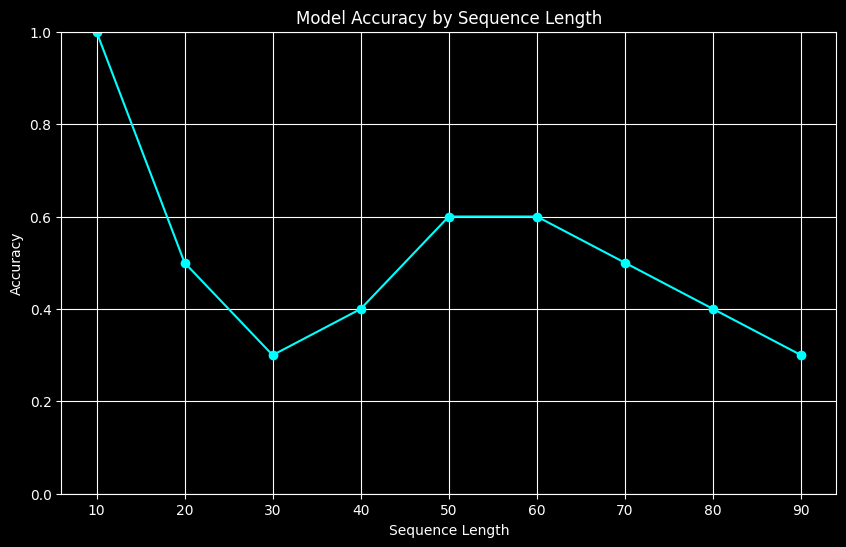

In [19]:
sequence_lengths = list(rnn_acc.keys())
accuracies = list(rnn_acc.values())
plt.figure(figsize=(10, 6))
plt.plot(sequence_lengths, accuracies, marker='o', color='cyan')
plt.title('Model Accuracy by Sequence Length', color='white')
plt.xlabel('Sequence Length', color='white')
plt.ylabel('Accuracy', color='white')
plt.ylim(0, 1) 
plt.grid(True)
plt.show()

### Task 4
Write a proper curricullum learning loop, where in a loop you consider longer and longer sequences, where expansion of the sequence length happens only after the model is trained successfully on the current length.

In [11]:
def curriculum_learning_loop():
    seq_len = 10
    acc, min_acc = 1.0, 0.7
    results = {}
    model = None

    while acc >= min_acc:
        data = generate_data(seq_len, 100)
        test_data = generate_data(seq_len, 10)
        model = train(hidden_dim=20, lr=0.1, num_steps=10, data=data)

        x, y = ([sequence for sequence, _ in test_data],
            [label for _, label in test_data])
        acc = eval_accuracy(model, x, y)

        results[seq_len] = acc
        print(f"Accuracy after training for seq_len={seq_len} : {acc}")
        seq_len += 1

    return model, results


_, results = curriculum_learning_loop()

100%|██████████| 10/10 [00:01<00:00,  8.69it/s]

Accuracy after training for seq_len=10 : 0.5
